## Titanic prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import svm

## Data cleaning

In [2]:
data = pd.read_csv("../Titanic/train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Since we do not need the name of each person, we remove it with a drop

In [3]:
data_train=data.drop("Name",axis=1)

Ticket number doesnt seem to help on the analysis so we drop it too

In [4]:
data_train=data_train.drop("Ticket",axis=1)

In [5]:
data_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,NaN,S
887,888,1,1,female,19.0,0,0,30.0000,B42,S
888,889,0,3,female,NaN,1,2,23.4500,NaN,S
889,890,1,1,male,26.0,0,0,30.0000,C148,C


In [6]:
data_train["Cabin"].isna().sum()

687

Since 70% of the Cabin data is a NaN value, and we (at least i) don't know the cabin positions in the Titanic, it is pretty hard to use this information, so we remove it too

In [7]:
data_train=data_train.drop("Cabin",axis=1)

First we will try a multi linear regression model to predict the survival chance of a person. To read better the data, we will make some plots first

(array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 342.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

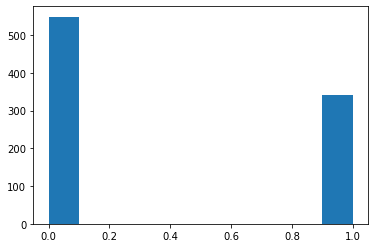

In [8]:
plt.hist(data_train["Survived"])

Notice that in our training set (Kaggle provides the dataset already splitted) most of the people did not survived.

Since we have some categorical variables (Sex and Embarked port) we convert it to boolean with dummies to make the predictions.

In [9]:
dat=pd.get_dummies(data_train["Sex"], prefix="Sex")

In [10]:
data_train["Sex_female"]=dat["Sex_female"]
data_train["Sex_male"]=dat["Sex_male"]

In [11]:
data_train=data_train.drop("Sex",axis=1)

In [12]:
dat2=pd.get_dummies(data_train["Embarked"], prefix="Embark")
data_train["Embark_C"]=dat2["Embark_C"]
data_train["Embark_Q"]=dat2["Embark_Q"]
data_train["Embark_S"]=dat2["Embark_S"]

In [13]:
data_train.groupby("Survived").mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embark_C,Embark_Q,Embark_S
Survived,,,,,,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887,0.147541,0.852459,0.136612,0.085610,0.777778
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408,0.681287,0.318713,0.271930,0.087719,0.634503


From the previous group by, we can see that (in average) the survival probability depends on the sex (female has a better percentage of survival about 68%) and the fare too (people who survived payed a higher fare in average).

Since we already created the dummies, we can remove the columns that we do not use on the future prediction (in particular de passenger id and the column Survived). We will call
X to data_train to ease the notation.

In [14]:
X= data_train.drop("PassengerId", axis=1)
X=data_train.drop("Survived",axis=1)
X

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male,Embark_C,Embark_Q,Embark_S
0,1,3,22.0,1,0,7.2500,S,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,C,1,0,1,0,0
2,3,3,26.0,0,0,7.9250,S,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,S,1,0,0,0,1
4,5,3,35.0,0,0,8.0500,S,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,27.0,0,0,13.0000,S,0,1,0,0,1
887,888,1,19.0,0,0,30.0000,S,1,0,0,0,1
888,889,3,NaN,1,2,23.4500,S,1,0,0,0,1
889,890,1,26.0,0,0,30.0000,C,0,1,1,0,0


We see from X that age column has some NaN values, we will count them first and then fill each value with the mean value of the column age; it is an standard procedure for recover some data in a stable way (we could also try with the median).

In [15]:
X["Age"].isna().sum()

177

In [16]:
X["Age"]=X["Age"].fillna(np.mean(X["Age"]))
X=X.drop("Embarked",axis=1)

In [17]:
Xcols=X.drop("PassengerId",axis=1).columns.tolist()

We call Y to the column of data that we want to predict i.e. the survival or not of each person.

In [18]:
Y=data_train["Survived"]

In [19]:
Xcols

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex_female',
 'Sex_male',
 'Embark_C',
 'Embark_Q',
 'Embark_S']

We now upload the data_test dataset provided by Kaggle

In [20]:

data_test=pd.read_csv("../Titanic/test.csv")

In [21]:
dat_t=pd.get_dummies(data_test["Sex"], prefix="Sex")
data_test["Sex_female"]=dat_t["Sex_female"]
data_test["Sex_male"]=dat_t["Sex_male"]
dat_t2=pd.get_dummies(data_test["Embarked"], prefix="Embark")
data_test["Embark_C"]=dat_t2["Embark_C"]
data_test["Embark_Q"]=dat_t2["Embark_Q"]
data_test["Embark_S"]=dat_t2["Embark_S"]

data_test["Age"]=data_test["Age"].fillna(np.mean(data_test["Age"]))



data_test["Fare"]=data_test["Fare"].fillna(np.mean(data_test["Fare"]))

# Prediction Methods

## Logistic Regression

We start with the classic logistic regression (we need it because is a classification problem). We will use  Sklearn for our models, and since the dataset is small we use the liblinear solver.


In [22]:
logm= linear_model.LogisticRegression(solver="liblinear",max_iter=1000)

In [23]:
logm.fit(X.drop("PassengerId",axis=1),Y)

LogisticRegression(max_iter=1000, solver='liblinear')

In [24]:
logm.score(X.drop("PassengerId",axis=1),Y)

0.8035914702581369

Notice that this score is calculated vs the Y column that we already now so it is in some manner fictitious. That's why we use the testing dataset provided by Kaggle and then we will upload the predictions to see our score.

In [25]:
predict_Logit=logm.predict(data_test[Xcols])

In [26]:
predict_Logit

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Now we add our prediction to the data_test dataset and extract the needed columns to send it to Kaggle

In [27]:
data_test["Survived"]=predict_Logit

In [28]:
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embark_C,Embark_Q,Embark_S,Survived
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,NaN,Q,0,1,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,NaN,S,1,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,NaN,Q,0,1,0,1,0,0
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,NaN,S,0,1,0,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,NaN,S,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,NaN,S,0,1,0,0,1,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C105,C,1,0,1,0,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,1,0,0,1,0
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,NaN,S,0,1,0,0,1,0


In [29]:
data_predicted=data_test[["PassengerId","Survived"]]

In [30]:
data_predicted

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [31]:
data_predicted.to_csv("submission.csv",index=None)

This prediction gaves us on Kaggle a 0.76555 Accuracy, it means that we gave the correct prediction for 
the 76% of the cases.

## Random Forest

Random forest is one of the most used and powerful classic algorithms for classification. Since it is very expensive, we need to be careful with the dataset size. In this case there is no problem because there are "few" data.

In [32]:
forest=RFC(n_jobs=2, oob_score=True, n_estimators=5000,max_depth=8)

In [33]:
forest.fit(X.drop("PassengerId",axis=1),Y)

RandomForestClassifier(max_depth=8, n_estimators=5000, n_jobs=2, oob_score=True)

In [34]:
forest.oob_score_

0.835016835016835

Notice that we get a slightly better scoring that the one for the regression. Now we make our estimations to charge it in 
Kaggle.

In [35]:
forestcols=X.drop("PassengerId",axis=1).columns.tolist()

In [36]:
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embark_C,Embark_Q,Embark_S,Survived
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,NaN,Q,0,1,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,NaN,S,1,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,NaN,Q,0,1,0,1,0,0
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,NaN,S,0,1,0,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,NaN,S,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,NaN,S,0,1,0,0,1,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C105,C,1,0,1,0,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,1,0,0,1,0
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,NaN,S,0,1,0,0,1,0


In [37]:
predict_f=forest.predict(data_test[forestcols])

In [38]:
data_test["Survived_Forest"]=predict_f

In [39]:
data_predict_forest=[data_test["PassengerId"],data_test["Survived_Forest"]]

In [40]:
data_predict_forest=pd.DataFrame(data_predict_forest)
data_predict_forest=pd.DataFrame.transpose(data_predict_forest)

In [41]:
data_predict_forest.rename(columns={"Survived_Forest":"Survived"},inplace=True)

In [42]:

data_predict_forest.to_csv("submission.csv",index=None)

We get an score of 0.777 which is slightly better than the one obtained in the linear regression.

# Support vector machine

Another very useful ML algorithm is the SVM. Again we will use the one that come with sklearn. This is a very sensible 
algorithm to use since it has hyperparameters C and gamma.

In [68]:
svc=svm.SVC(kernel="rbf",C=5.0,gamma='auto', decision_function_shape="ovr",degree=2).fit(X.drop("PassengerId",axis=1),Y)

In [72]:
svc.score(X.drop("PassengerId",axis=1),Y)

0.8249158249158249

Notice that this prediction has a very high score. Anyway, it can be a case of overfitting due to the choice of the hyperparameters. Let's see what happens with the prediction and Kaggle

In [73]:
predict_svc=svc.predict(data_test[forestcols])

In [74]:
data_test["Survived_SVM"]=predict_svc

In [75]:
data_predict_svm=[data_test["PassengerId"],data_test["Survived_SVM"]]

data_predict_svm=pd.DataFrame(data_predict_svm)
data_predict_svm=pd.DataFrame.transpose(data_predict_svm)

data_predict_svm.rename(columns={"Survived_SVM":"Survived"},inplace=True)


data_predict_svm.to_csv("submission.csv",index=None)

The score is of 0.62 !!! this means that the algorithm is clearly overfitting.

We could keep trying with other kernels and/or change the hyperparameters.

Using the following code can be gotten a score of 0.77990 

In [71]:
svc=svm.SVC(kernel="poly",C=1.0,gamma=0.10, decision_function_shape="ovr",degree=2).fit(X.drop("PassengerId",axis=1),Y)

  # Choose the majority

Now that we have 3 different prediction algorithms with almost the same accuracy, we can do the same argument as a random forest; take the tree predictions, compare them and keep the most "voted result". Let's see if this improves the accuracy.

In [77]:
W=[data_test["PassengerId"],data_test["Survived"],data_test["Survived_Forest"],data_test["Survived_SVM"]]

In [78]:
W=pd.DataFrame(W)
W=pd.DataFrame.transpose(W)


In [80]:
W["Sums"]=data_test["Survived"]+data_test["Survived_Forest"]+data_test["Survived_SVM"]
Survived=np.where(W["Sums"]>=2, 1, 0)
        
    

In [81]:
Survived

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [85]:

majority_vote=[data_test["PassengerId"],Survived]

majority_vote=pd.DataFrame(majority_vote)
majority_vote=pd.DataFrame.transpose(majority_vote)
majority_vote.rename(columns={"Unnamed 0":"Survived"}, inplace=True)
majority_vote

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [86]:

majority_vote.to_csv("submission.csv",index=None)

With this technique we get an score of 0.78229, that improves all the previous obtained.

# Discussion and conclusions

We can see from the previous arguments that:
   1. All the algorithms proposed have similar accuracy;  in fact the Majority vote is the best of all.
   2. We could try to improve our data analysis for a better predicion; in particular, check carefully if the age completion with the mean was the best option.
   3. The analysis consider all the "usable" variables; it is not exposed here but the algorithms predict better taking all these variables (can be checked that removing some of the variables, the prediction accuracy decreases).
   4. 78% of accuracy is pretty good if we consider that we can predict almost 8 of 10 cases correctly, only with a few simple algorithms.